### 导入模拟数据

使用模拟数据，测试模型

In [1]:
import os
import numpy as np
import tensorflow as tf

os.chdir("/home/num_24/桌面/mywork/github/TFDeepSurv")
os.getcwd()

np.random.seed(10)

from dataset import SimulatedData
import LDeepSurv as LDS

data_config = SimulatedData(1000, num_var = 2, num_features = 10)
data = data_config.generate_data(2000)
sort_idx = np.argsort(data['t'])[::-1]
data['x'] = data['x'] [sort_idx]
data['e'] = data['e'] [sort_idx]
data['t'] = data['t'] [sort_idx]

### 模型训练

设置网络参数：
- 隐藏层：[6, 3]
- 学习率：learning_rate=0.001
- 激活函数：activation='tanh',
- 正则化参数：L1_reg=0.01, L2_reg=0.01,
- 优化算法：optimizer='sgd'

训练参数：
- 迭代次数：num_epoch=3000

features:  10
-------------------------------------------------
training steps 1:
loss = 10595.2.

CI = 0.498654.

-------------------------------------------------
training steps 501:
loss = 9892.56.

CI = 0.761914.

-------------------------------------------------
training steps 1001:
loss = 9804.2.

CI = 0.777563.

-------------------------------------------------
training steps 1501:
loss = 9735.12.

CI = 0.787206.

-------------------------------------------------
training steps 2001:
loss = 9811.72.

CI = 0.779378.

-------------------------------------------------
training steps 2501:
loss = 9777.43.

CI = 0.781882.



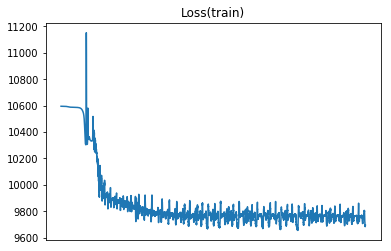

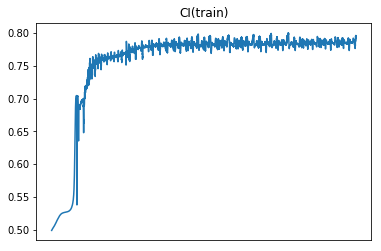

In [2]:
n_features = data['x'].shape[1]
print("features: ", n_features)
model = LDS.LDeepSurv(n_features, [6, 3], 1, 
                      learning_rate=0.001,
                      activation='tanh', 
                      L1_reg=0.01, 
                      L2_reg=0.01, 
                      optimizer='sgd')

model.train(data['x'], {'e': data['e'], 't': data['t']}, 
            num_epoch=3000, iteration=500,
            plot_train_loss=True, plot_train_CI=True)

### 网络测试

使用一致性指数评估（CI）:
- 训练集上的评估
- 独立测试集上的评估

In [3]:
X = data['x']
label = {'e': data['e'], 't': data['t']}
print("CI on train set: %g" % model.eval(X, label))

# 生成测试集数据
test_data = data_config.generate_data(800)
sort_idx = np.argsort(test_data['t'])[::-1]
test_data['x'] = test_data['x'] [sort_idx]
test_data['e'] = test_data['e'] [sort_idx]
test_data['t'] = test_data['t'] [sort_idx]
test_X = test_data['x']
test_label = {'e': test_data['e'], 't': test_data['t']}
print("CI on train set: %g" % model.eval(test_X, test_label))

CI on train set: 0.790826
CI on train set: 0.780111


In [4]:
model.evaluate_var_byWeights()

0th feature score : 1.
1th feature score : -0.783566.
2th feature score : 0.0200286.
3th feature score : 0.00529143.
4th feature score : -0.0432767.
5th feature score : 0.0329239.
6th feature score : -0.0408267.
7th feature score : 0.0221015.
8th feature score : -0.0728189.
9th feature score : 0.0024426.


array([ 1.        , -0.78356618,  0.02002862,  0.00529143, -0.04327673,
        0.03292394, -0.04082675,  0.02210155, -0.07281888,  0.0024426 ], dtype=float32)

### 不同个体的生存函数预测

比例风险模型：$$h(t|x) = h_0(t)\cdot e^{\beta \cdot x}$$
对应的生存函数关系：$$S(t|x) = S_0(t)^{e^{\beta \cdot x}}$$

采用不同的估计方法得到**基准生存函数**：
$$S_0(t) = \prod_{i: t_i < t} C_i$$
- WWE方法：允许ties出现，论文中提出的新的估计方法；
- KP方法：未考虑ties的出现；
- bls方法：考虑了ties的出现， 但是可能会出现负值。

In [5]:
# 得到基准生存函数（基于整个训练数据人群）
# wwe方法：
T0_wwe, S0_wwe = model.basesurv(algo='wwe')
# KP方法：
T0_kp, S0_kp = model.basesurv(algo='kp')
# wwe方法：
T0_bsl, S0_bsl = model.basesurv(algo='bsl')

print("wwe : ", S0_wwe)
print("kp : ", S0_kp)
print("bsl : ", S0_bsl)

wwe :  [ 1.          0.99993654  0.99987308 ...,  0.32016194  0.32016194
  0.32016194]
kp :  [ 1.          0.99993659  0.99987313 ...,  0.32032877  0.32032877
  0.32032877]
bsl :  [ 1.          0.99993664  0.99987318 ...,  0.32049484  0.32049484
  0.32049484]


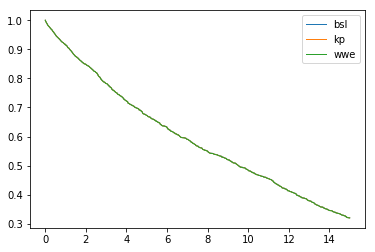

In [6]:
# 在同一个图中（使用同一训练数据，三种对基准生存函数不同的估计方法）
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
data = pd.DataFrame({'wwe': S0_wwe, 'kp': S0_kp, 'bsl': S0_bsl}, index = T0_wwe)
data.plot(lw=1)

预测特定个体的生存曲线：

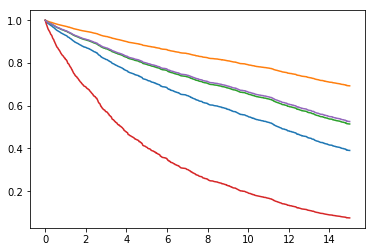

(array([  0.00000000e+00,   5.01984323e-04,   1.33719447e-03, ...,
          1.50000000e+01,   1.50000000e+01,   1.50000000e+01], dtype=float32),
 array([[ 1.        ,  0.99994762,  0.99989525, ...,  0.39063885,
          0.39063885,  0.39063885],
        [ 1.        ,  0.99997957,  0.99995914, ...,  0.69307828,
          0.69307828,  0.69307828],
        [ 1.        ,  0.99996297,  0.99992593, ...,  0.51445506,
          0.51445506,  0.51445506],
        [ 1.        ,  0.99985563,  0.99971127, ...,  0.07493523,
          0.07493523,  0.07493523],
        [ 1.        ,  0.99996421,  0.99992841, ...,  0.52603465,
          0.52603465,  0.52603465]]))

In [7]:
model.survivalRate(X[0:5], algo="wwe")

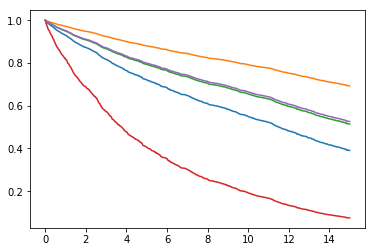

(array([  0.00000000e+00,   5.01984323e-04,   1.33719447e-03, ...,
          1.50000000e+01,   1.50000000e+01,   1.50000000e+01], dtype=float32),
 array([[ 1.        ,  0.99994767,  0.99989529, ...,  0.39080684,
          0.39080684,  0.39080684],
        [ 1.        ,  0.99997959,  0.99995916, ...,  0.69319451,
          0.69319451,  0.69319451],
        [ 1.        ,  0.99996299,  0.99992596, ...,  0.51461148,
          0.51461148,  0.51461148],
        [ 1.        ,  0.99985574,  0.99971138, ...,  0.0750241 ,
          0.0750241 ,  0.0750241 ],
        [ 1.        ,  0.99996423,  0.99992844, ...,  0.52618924,
          0.52618924,  0.52618924]]))

In [8]:
model.survivalRate(X[0:5], algo="kp")

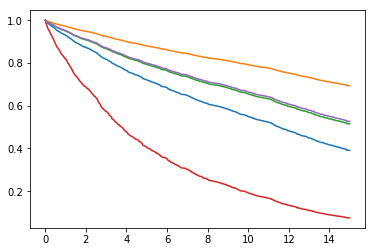

(array([  0.00000000e+00,   5.01984323e-04,   1.33719447e-03, ...,
          1.50000000e+01,   1.50000000e+01,   1.50000000e+01], dtype=float32),
 array([[ 1.        ,  0.99994771,  0.99989533, ...,  0.39097405,
          0.39097405,  0.39097405],
        [ 1.        ,  0.9999796 ,  0.99995917, ...,  0.69331018,
          0.69331018,  0.69331018],
        [ 1.        ,  0.99996302,  0.99992599, ...,  0.51476716,
          0.51476716,  0.51476716],
        [ 1.        ,  0.99985585,  0.99971149, ...,  0.07511262,
          0.07511262,  0.07511262],
        [ 1.        ,  0.99996426,  0.99992847, ...,  0.52634309,
          0.52634309,  0.52634309]]))

In [9]:
model.survivalRate(X[0:5], algo="bsl")

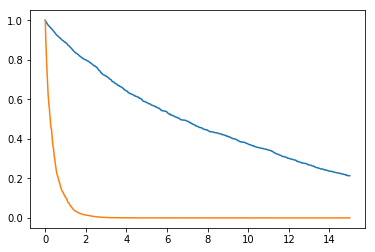

(array([  0.00000000e+00,   5.01984323e-04,   1.33719447e-03, ...,
          1.50000000e+01,   1.50000000e+01,   1.50000000e+01], dtype=float32),
 array([[  1.00000000e+00,   9.99913904e-01,   9.99827808e-01, ...,
           2.13273082e-01,   2.13273082e-01,   2.13273082e-01],
        [  1.00000000e+00,   9.98378312e-01,   9.96759115e-01, ...,
           2.24011509e-13,   2.24011509e-13,   2.24011509e-13]]))

In [10]:
model.survivalRate(X[-2:], algo='wwe')

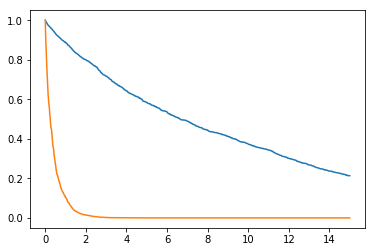

(array([  0.00000000e+00,   5.01984323e-04,   1.33719447e-03, ...,
          1.50000000e+01,   1.50000000e+01,   1.50000000e+01], dtype=float32),
 array([[  1.00000000e+00,   9.99913971e-01,   9.99827876e-01, ...,
           2.13423868e-01,   2.13423868e-01,   2.13423868e-01],
        [  1.00000000e+00,   9.98379574e-01,   9.96760393e-01, ...,
           2.27015877e-13,   2.27015877e-13,   2.27015877e-13]]))

In [11]:
model.survivalRate(X[-2:], algo='kp')

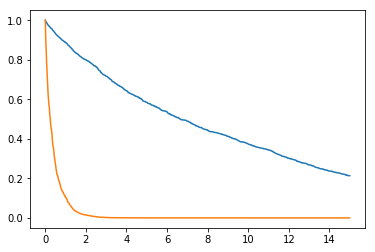

(array([  0.00000000e+00,   5.01984323e-04,   1.33719447e-03, ...,
          1.50000000e+01,   1.50000000e+01,   1.50000000e+01], dtype=float32),
 array([[  1.00000000e+00,   9.99914038e-01,   9.99827944e-01, ...,
           2.13574000e-01,   2.13574000e-01,   2.13574000e-01],
        [  1.00000000e+00,   9.98380835e-01,   9.96761670e-01, ...,
           2.30045110e-13,   2.30045110e-13,   2.30045110e-13]]))

In [12]:
model.survivalRate(X[-2:], algo='bsl')

采用原来代码中的方法进行估计：

原来代码中估计方法为：
- 先估计基准风险函数$h_0(t_i)=1-c_i$，$c_i$采用K&P方法计算得到，同时累积求和，得到$H_0(t_i)$ (这个就是累积基准风险函数么？)。
- 根据比例风险模型公式，由网络预测得到比例风险后，得到$h(t|x) = h_0(t)\cdot e^{\beta \cdot x}$，累积风险函数同样适用于这个公式，即：$H(t|x) = H_0(t)\cdot e^{\beta \cdot x}$；
- 再由公式$H_0(t) = -In S_0(t), S_0(t) = e^{-H_0(t)}$，从而得到生存函数。

公式$H_0(t) = -In S_0(t), S_0(t) = e^{-H_0(t)}$中，$H_0(t)$指的是累积风险函数，而累积风险函数与风险函数的关系为：
$$H_0(t) = \int_{0}^{t} h_0(x) dx$$

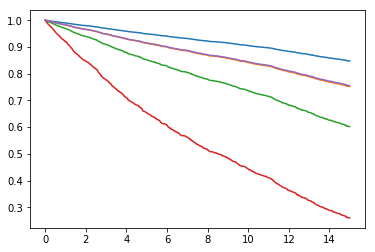

(array([  0.00000000e+00,   5.01984323e-04,   1.33719447e-03, ...,
          1.50000000e+01,   1.50000000e+01,   1.50000000e+01], dtype=float32),
 array([[ 1.        ,  0.99999399,  0.99998798, ...,  0.84792306,
          0.84792306,  0.84792306],
        [ 1.        ,  0.99998962,  0.99997922, ...,  0.75189372,
          0.75189372,  0.75189372],
        [ 1.        ,  0.99998152,  0.99996303, ...,  0.60201581,
          0.60201581,  0.60201581],
        [ 1.        ,  0.99995095,  0.99990187, ...,  0.26003243,
          0.26003243,  0.26003243],
        [ 1.        ,  0.99998979,  0.99997957, ...,  0.75542358,
          0.75542358,  0.75542358]]),
 array([ 5.        ,  4.99990587,  4.99981167, ...,  3.2172886 ,
         3.2172886 ,  3.2172886 ]))

In [5]:
model.survivalRate(X[0:5])

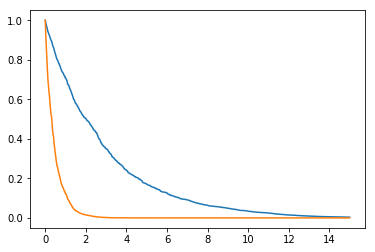

(array([  0.00000000e+00,   5.01984323e-04,   1.33719447e-03, ...,
          1.50000000e+01,   1.50000000e+01,   1.50000000e+01], dtype=float32),
 array([[  1.00000000e+00,   9.99796395e-01,   9.99592685e-01, ...,
           3.72875930e-03,   3.72875930e-03,   3.72875930e-03],
        [  1.00000000e+00,   9.98770770e-01,   9.97542171e-01, ...,
           2.14411286e-15,   2.14411286e-15,   2.14411286e-15]]),
 array([ 2.        ,  1.99856716,  1.99713486, ...,  0.00372876,
         0.00372876,  0.00372876]))

In [9]:
model.survivalRate(X[-2:])

### 总结

- 网络需要参数需要优化，调整（自动化调参？贝叶斯优化参数？）
- 网络性能波动很大，最终网络对比例风险的估计存在波动（每次实验结果都不一样，随机数种子的问题？）
- 网络对特征重要性的评估：不稳定，不准确，存在负重要性分数！（采用模拟数据，有时候得到的特征重要性偏差很大）
- 对生存函数的估计？

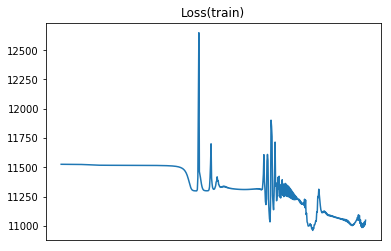

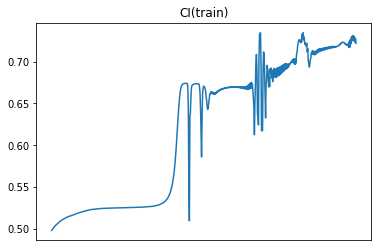

In [6]:
model0 = LDS.LDeepSurv(n_features, [6,3], 1, learning_rate=0.001, activation='tanh', L2_reg=0.01, optimizer='adam')

model0.train(data['x'], {'e': data['e'], 't': data['t']}, num_epoch=600, plot_train_loss=True, plot_train_CI=True)

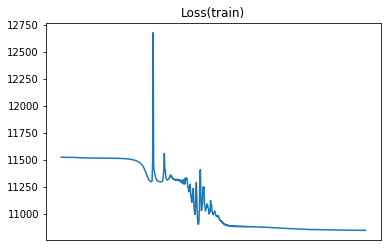

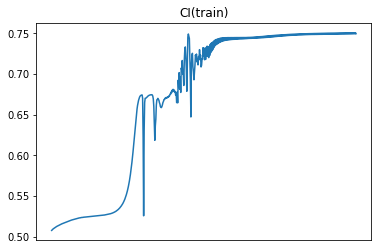

In [4]:
model2 = LDS.LDeepSurv(n_features, [6,3], 1, learning_rate=0.001, activation='tanh', L2_reg=0.01, optimizer='adam')

model2.train(data['x'], {'e': data['e'], 't': data['t']}, num_epoch=600, plot_train_loss=True, plot_train_CI=True)

features:  10


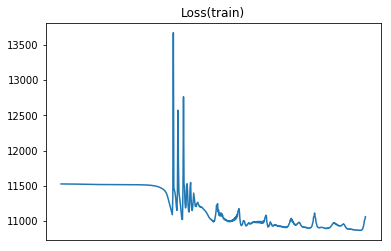

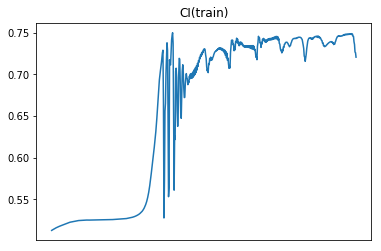

In [3]:
n_features = data['x'].shape[1]
print("features: ", n_features)
model = LDS.LDeepSurv(n_features, [6,3], 1, learning_rate=0.001, activation='tanh', L2_reg=0.01)

model.train(data['x'], {'e': data['e'], 't': data['t']}, num_epoch=600, plot_train_loss=True, plot_train_CI=True)

In [3]:
import tensorflow as tf

print(tf.global_variables())

[<tf.Variable 'layer1/weights:0' shape=(10, 6) dtype=float32_ref>, <tf.Variable 'layer1/biases:0' shape=(6,) dtype=float32_ref>, <tf.Variable 'layer2/weights:0' shape=(6, 3) dtype=float32_ref>, <tf.Variable 'layer2/biases:0' shape=(3,) dtype=float32_ref>, <tf.Variable 'layer_last/weights:0' shape=(3, 1) dtype=float32_ref>, <tf.Variable 'layer_last/biases:0' shape=(1,) dtype=float32_ref>, <tf.Variable 'training_step/global_step:0' shape=() dtype=int32_ref>]


In [4]:
with tf.Session() as sess:
    c = tf.get_collection('losses')
    x = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    y = tf.get_collection(tf.GraphKeys.WEIGHTS)
    print(c, x, y)

[] [<tf.Tensor 'layer1/weights/Regularizer/l1_l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'layer2/weights/Regularizer/l1_l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'layer_last/weights/Regularizer/l1_l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'get_regularization_penalty:0' shape=() dtype=float32>] []


In [5]:
print(tf.trainable_variables())

[<tf.Variable 'layer1/weights:0' shape=(10, 6) dtype=float32_ref>, <tf.Variable 'layer1/biases:0' shape=(6,) dtype=float32_ref>, <tf.Variable 'layer2/weights:0' shape=(6, 3) dtype=float32_ref>, <tf.Variable 'layer2/biases:0' shape=(3,) dtype=float32_ref>, <tf.Variable 'layer_last/weights:0' shape=(3, 1) dtype=float32_ref>, <tf.Variable 'layer_last/biases:0' shape=(1,) dtype=float32_ref>]
